In [1]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/

/work/clusterEvo/new_tests


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr

In [3]:
spr_distances  = pd.DataFrame(index  =['tree_%i' % num for num in range(1, 51)],
                              columns=['tree_%i' % num for num in range(1, 51)],
                              data   =[abs(np.arange(50)-n) for n in range(50)])
condensed_spr_distances = squareform(spr_distances)
spr_distances.head()

,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9,tree_10,...,tree_41,tree_42,tree_43,tree_44,tree_45,tree_46,tree_47,tree_48,tree_49,tree_50
tree_1,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
tree_2,1,0,1,2,3,4,5,6,7,8,...,39,40,41,42,43,44,45,46,47,48
tree_3,2,1,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
tree_4,3,2,1,0,1,2,3,4,5,6,...,37,38,39,40,41,42,43,44,45,46
tree_5,4,3,2,1,0,1,2,3,4,5,...,36,37,38,39,40,41,42,43,44,45


In [44]:
def run_coevol_subsample(matrices):
    source_matrix1 = matrices[0].copy()
    source_matrix2 = matrices[1].copy()

    shared_genomes = np.intersect1d(source_matrix1.index, 
                                    source_matrix2.index)
    
    r2s = []
    while len(shared_genomes) > 25:
    
        shared_genomes = random.sample(list(shared_genomes), len(shared_genomes) - 25)
        
        matrix1 = source_matrix1.reindex(index  =shared_genomes, 
                                  columns=shared_genomes, 
                                  copy   =True)
        matrix2 = source_matrix2.reindex(index  =shared_genomes, 
                                  columns=shared_genomes, 
                                  copy   =True)

        condensed1 = squareform(matrix1.values, checks=False)
        condensed2 = squareform(matrix2.values, checks=False)

        odr_weights = estimate_weights(condensed1, condensed2)
#         odr_weights = (1, 1)

        regression = run_odr(condensed1, 
                             condensed2, 
                             *odr_weights)

        mean_x = np.mean(condensed1)
        mean_y = np.mean(condensed2)

        mean_pred_x = regression.xplus.mean()
        mean_pred_y = regression.y.mean()

        x_SSres = sum(regression.delta**2)
        y_SSres = sum(regression.eps  **2)
        SSres   = x_SSres + y_SSres

        x_SSreg = sum(
            (regression.xplus - mean_pred_x)**2
        )
        y_SSreg = sum(
            (regression.y     - mean_pred_y)**2
        )
        SSreg   = x_SSreg + y_SSreg

        x_SStot = sum(
            (condensed1 - mean_x)**2
        )
        y_SStot = sum(
            (condensed2 - mean_y)**2
        )
        SStot   = x_SStot + y_SStot

        r2 = 1 - SSres/SStot
        
        r2s.append(r2)

    return(r2s)

matrix1 = dist_matrices[0].copy()
matrix2 = dist_matrices[9].copy()
run_coevol_subsample((matrix1, matrix2))

[0.6396579543603294]

In [45]:
datasets = {}
for n in range(1, 11):
    print(n)
    with cd(f'set{n}/'):
        alignment_file_names = [f'alignments/tree_{_}.phy' for _ in range(1, 51)]

        pool          = multiprocessing.Pool(processes = 10)
        dist_matrices = pool.map(run_dist_matrix, alignment_file_names)

    regressions, r2s, subsampled_r2s = [], [], []
    for (matrix1, matrix2), spr_count in zip(itertools.combinations(dist_matrices, 
                                                                2), 
                                             condensed_spr_distances):
        tmp_reg, tmp_r2 = assess_coevolution(matrix1, matrix2, geneIDs=False)
        regressions.append(tmp_reg)
        r2s.append(tmp_r2)
        
        if 10 <= spr_count <= 15:
            print(tmp_r2)
            subsampled_r2s.append([tmp_r2])
            subsampled_r2s[-1].extend(run_coevol_subsample((matrix1, matrix2)))

    break

1
0.685801669837719
0.6614586551650895
0.5861059229409598
0.5555743377762603
0.5620528022171586
0.5527053610417144
0.6709628289069414
0.6035240481116901
0.5787719115140854
0.5645358123155374
0.5626623853033847
0.5694963694904507
0.6000575894631158
0.5710653221322814
0.5697447564030859
0.562014262746479
0.5660458102485981
0.5775339079260225
0.5637821214543636
0.5595819607652209
0.5588191337509043
0.5557565294979943
0.5726045783707565
0.5274352484226262
0.6019870616016632
0.6323865110675146
0.6308793760240533
0.608332997694398
0.5497640109482396
0.5472848223639617
0.6208959060618552
0.6358339682230907
0.6070469635554823
0.5737757213873623
0.5646013264116816
0.5418442549446598
0.6481729441776838
0.6049646390662133
0.5669135628456351
0.5526624484388422
0.5612102771719185
0.5563418150860509
0.6141112293032291
0.5838906250783475
0.5789011545287657
0.540547337249957
0.529470544833345
0.5187542406183756
0.6035747587333478
0.5854206370308015
0.5681905905177271
0.5607360903867127
0.5436566263000

In [46]:
subsampled_r2s[0]

[0.685801669837719, 0.6793935109502813]

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3049: RuntimeWarning:

invalid value encountered in double_scalars



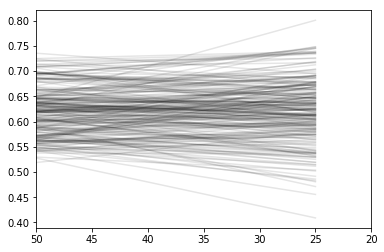

In [47]:
x = [50, 25]

fig, ax = plt.subplots()
ax.set_xlim(50, 20)  # decreasing time

pearsons = []
for y in subsampled_r2s:
    pearsons.append(pearsonr(x, y)[0])
    sns.lineplot(x=x, y=y,
                 ax=ax,
                 color='black',
                 alpha=0.1)

In [34]:
x

[50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

In [35]:
y

[0.8393893302043645,
 0.8261062477056188,
 0.8025914077693783,
 0.80560058451264,
 0.8317592426137124,
 0.8120451324513481,
 0.8233047795334364,
 0.7949795897193649,
 0.6596912615378628,
 0.4585617071346193]

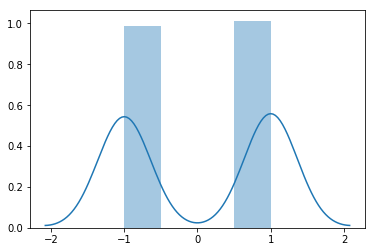

In [48]:
sns.distplot(pearsons)